In [1]:
%%capture stored_output
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn as sns
import pandas as pd
import os
from tqdm import tqdm
import datetime

os.chdir("..")
import d3rlpy

import warnings

warnings.filterwarnings("ignore")

from augrl import utils

## Comparing results

In [3]:
LOGS_DIR = "d3rlpy_logs/"
STEPS_PER_EPOCH = 2000
EXCLUDED_ALGOS = []
EXCLUDED_ENVS = []
SCORERS = [
    "evaluate_on_environment",
    "td_error_scorer",
    "initial_state_value_estimation_scorer",
    "discounted_sum_of_advantage_scorer",
]

In [4]:
models = {}
for subdir, dirs, files in os.walk(LOGS_DIR):
    for file in files:
        model_file = os.path.join(subdir, file)
        if "model" in model_file:
            # TODO with a regex
            data_ratio = model_file.split("/")[2].split("_")[0].lower()
            env_name = model_file.split("/")[2].split("_")[1].lower()
            algo_name = model_file.split("/")[2].split("_")[2].lower()
            if (data_ratio, algo_name, env_name) in models.keys():
                models[(data_ratio, algo_name, env_name)].append(model_file)
            else:
                models[(data_ratio, algo_name, env_name)] = [model_file]

In [5]:
results = []
bar = tqdm(total=sum(len(files) for files in models.values()))
for data_ratio, algo_name, env_name in models.keys():
    is_discrete = "discrete" in algo_name
    algo_ = utils.get_algo(algo_name.replace("discrete", ""), is_discrete)
    dataset, env = utils.get_dataset(env_name)
    scorer_fns = utils.get_scorers(
        SCORERS, env=env, discrete=is_discrete, env_evaluation_trials=10
    )
    # build algo
    algo = algo_()
    algo.build_with_env(env)
    for model_file in models[(data_ratio, algo_name, env_name)]:
        step_ = int(model_file.split("_")[-1].replace(".pt", ""))
        algo.load_model(model_file)
        metrics = utils.get_metrics(scorer_fns, algo, dataset)
        results.append(
            utils.merge_dicts(
                {
                    "env": env_name,
                    "algo": "{} {}".format(
                        data_ratio, algo_name.replace("discrete", "")
                    ),
                    "steps": step_,
                },
                metrics,
            )
        )
        bar.update(1)
bar.close()
results_df = pd.DataFrame(results)

100%|██████████| 20/20 [05:10<00:00, 15.52s/it]


In [6]:
results_df2 = results_df
results_df.to_parquet(
    "results/cloud_results_{}.parquet".format(
        datetime.datetime.now().strftime("%d%m%Y_%H%M")
    )
)

In [7]:
results_df_filter = results_df[
    ~results_df["env"].isin(EXCLUDED_ENVS) & ~results_df["algo"].isin(EXCLUDED_ALGOS)
]

In [8]:
# keep colors across plots
palette_dict = {
    continent: color
    for continent, color in zip(
        results_df_filter["algo"].unique(), sns.color_palette("tab10")
    )
}

### Reward - value

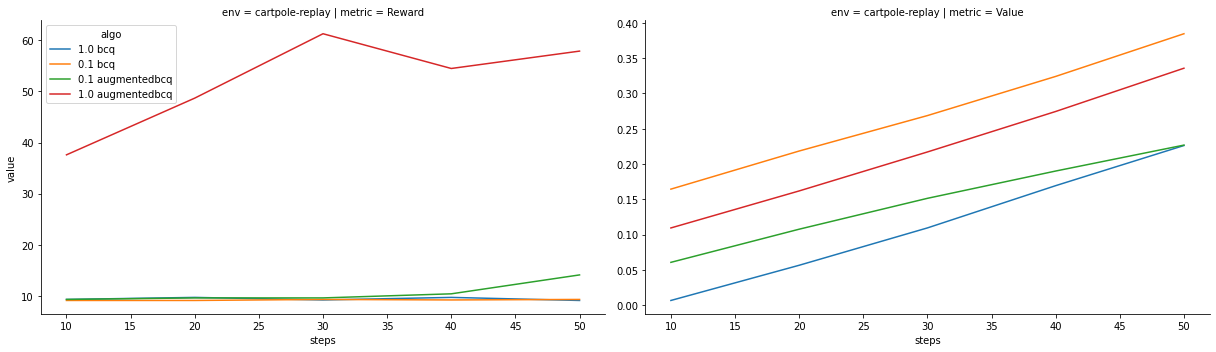

In [9]:
results_value = results_df_filter[
    ["env", "algo", "initial_state_value_estimation_scorer", "steps"]
].dropna()
results_reward = results_df_filter[
    ["env", "algo", "evaluate_on_environment", "steps"]
].dropna()
results_reward = results_reward.rename({"evaluate_on_environment": "value"}, axis=1)
results_value = results_value.rename(
    {"initial_state_value_estimation_scorer": "value"}, axis=1
)
results_reward["metric"] = "Reward"
results_value["metric"] = "Value"
res = pd.concat([results_reward, results_value])
g = sns.FacetGrid(
    res,
    col="metric",
    hue="algo",
    row="env",
    height=5,
    aspect=1.7,
    legend_out=False,
    sharey=False,
    sharex=False,
    palette=palette_dict,
)
g.map_dataframe(sns.lineplot, "steps", "value")
g.add_legend()

### TD - advantage

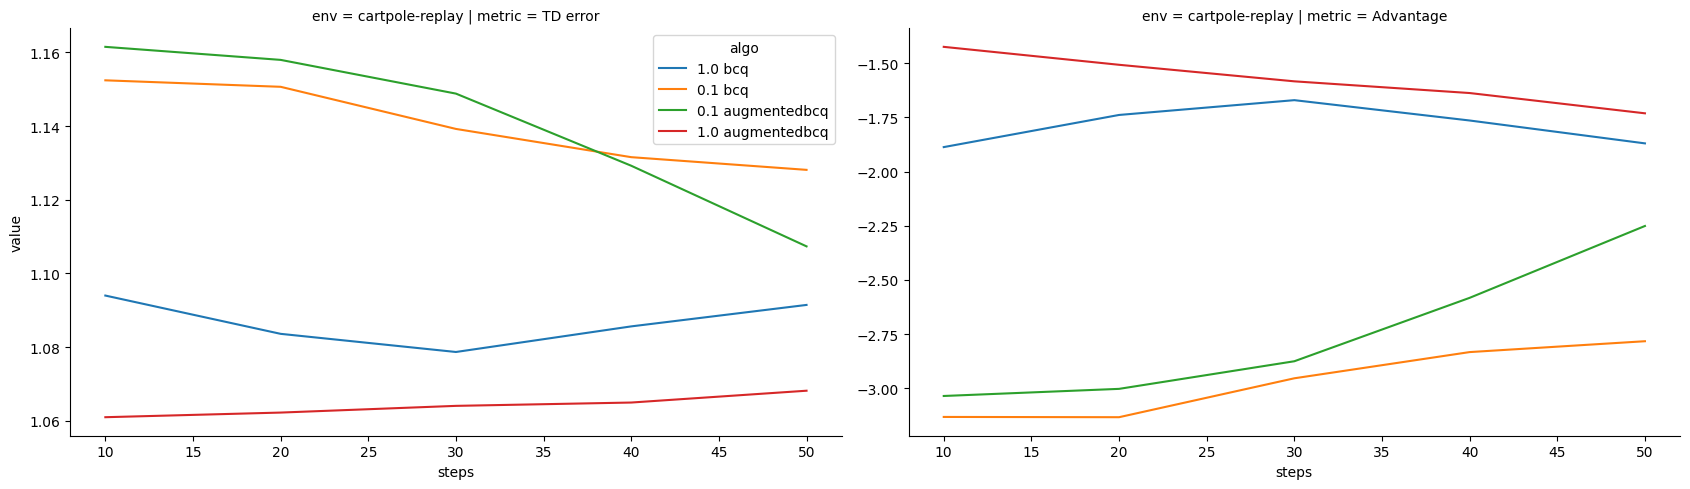

In [10]:
results_advantage = results_df_filter[
    ["env", "algo", "discounted_sum_of_advantage_scorer", "steps"]
].dropna()
results_td = results_df_filter[["env", "algo", "td_error_scorer", "steps"]].dropna()
results_td = results_td.rename({"td_error_scorer": "value"}, axis=1)
results_advantage = results_advantage.rename(
    {"discounted_sum_of_advantage_scorer": "value"}, axis=1
)
results_td["metric"] = "TD error"
results_advantage["metric"] = "Advantage"
res_2 = pd.concat([results_td, results_advantage])
g = sns.FacetGrid(
    res_2,
    col="metric",
    hue="algo",
    row="env",
    height=5,
    aspect=1.7,
    legend_out=False,
    sharey=False,
    sharex=False,
    palette=palette_dict,
)
g.map_dataframe(sns.lineplot, "steps", "value")
g.add_legend()

## Max reward

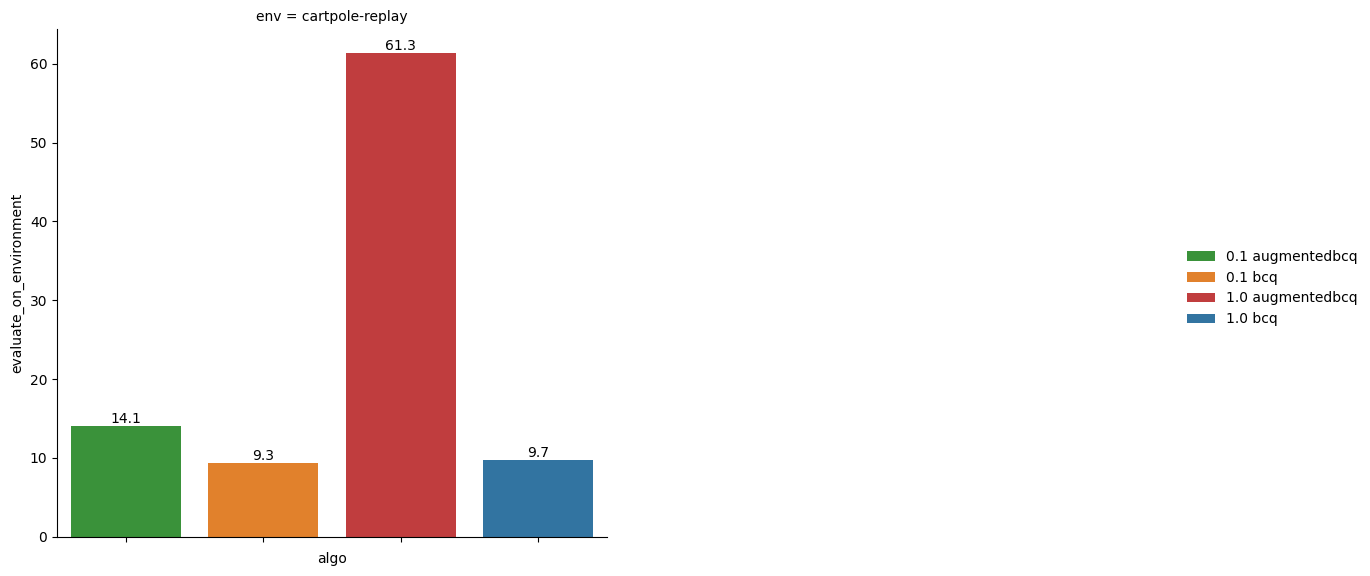

In [11]:
res_max = results_df[["env", "algo", "evaluate_on_environment"]].dropna()
res_max = res_max.groupby(["env", "algo"]).max().reset_index()
g = sns.catplot(
    data=res_max,
    x="algo",
    hue="algo",
    y="evaluate_on_environment",
    col="env",
    col_wrap=2,
    kind="bar",
    height=6,
    dodge=False,
    palette=palette_dict,
    legend=True,
    sharey=False,
    sharex=False,
)
g.add_legend()
g.set(xticklabels=[])
axs = [g.facet_axis(0, i) for i in range(res_max["env"].nunique())]
for ax in axs:
    for c in ax.containers:
        labels = [f"{(v.get_height()):.1f}" for v in c]
        ax.bar_label(c, labels=labels, label_type="edge")